In [1]:
from lightgbm import LGBMRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import itertools

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r"C:\Users\Lenovo\Python workshop\project\merged_data.csv", sep=",")
df.head()

,Date,Time,ResidualNoWinsorCumReturn,RawNoWinsorCumReturn,estVol,SharesOutstanding,MDV_63,CleanMid,CumVolume,IsOpen,ResidualNoWinsorCumReturn winsorized,RawNoWinsorCumReturn winsorized,estVol winsorized,SharesOutstanding winsorized,MDV_63 winsorized,CleanMid winsorized,CumVolume winsorized
0,20140102,10:00:00.000,0.008795,0.008043,0.093123,110.580,4321539.0,32.009570,30851.0,1.0,0.008795,0.008043,0.093123,110.580,4321539.0,32.009570,30851.0
1,20140102,10:00:00.000,-0.007513,-0.008949,0.129865,449.750,7728599.0,5.929723,100377.0,1.0,-0.007513,-0.008949,0.129865,449.750,7728599.0,5.929723,100377.0
2,20140102,10:00:00.000,0.002052,0.001240,0.151308,227.481,34529812.0,46.881290,118814.0,1.0,0.002052,0.001240,0.151308,227.481,34529812.0,46.881290,118814.0
3,20140102,10:00:00.000,-0.007269,-0.006079,0.122016,575.375,2318102.2,6.155510,57972.0,1.0,-0.007269,-0.006079,0.122016,575.375,2318102.2,6.155510,57972.0
4,20140102,10:00:00.000,-0.004682,-0.009140,0.066838,839.394,66501836.0,27.234093,399523.0,1.0,-0.004682,-0.009140,0.066838,839.394,66501836.0,27.234093,399523.0


In [3]:
df['Year'] = df.Date.apply(lambda x: int(str(x)[:4])-2014)
df['Month'] = df.Date.apply(lambda x: int(str(x)[4:6]))
df.head()

,Date,Time,ResidualNoWinsorCumReturn,RawNoWinsorCumReturn,estVol,SharesOutstanding,MDV_63,CleanMid,CumVolume,IsOpen,ResidualNoWinsorCumReturn winsorized,RawNoWinsorCumReturn winsorized,estVol winsorized,SharesOutstanding winsorized,MDV_63 winsorized,CleanMid winsorized,CumVolume winsorized,Year,Month
0,20140102,10:00:00.000,0.008795,0.008043,0.093123,110.580,4321539.0,32.009570,30851.0,1.0,0.008795,0.008043,0.093123,110.580,4321539.0,32.009570,30851.0,0,1
1,20140102,10:00:00.000,-0.007513,-0.008949,0.129865,449.750,7728599.0,5.929723,100377.0,1.0,-0.007513,-0.008949,0.129865,449.750,7728599.0,5.929723,100377.0,0,1
2,20140102,10:00:00.000,0.002052,0.001240,0.151308,227.481,34529812.0,46.881290,118814.0,1.0,0.002052,0.001240,0.151308,227.481,34529812.0,46.881290,118814.0,0,1
3,20140102,10:00:00.000,-0.007269,-0.006079,0.122016,575.375,2318102.2,6.155510,57972.0,1.0,-0.007269,-0.006079,0.122016,575.375,2318102.2,6.155510,57972.0,0,1
4,20140102,10:00:00.000,-0.004682,-0.009140,0.066838,839.394,66501836.0,27.234093,399523.0,1.0,-0.004682,-0.009140,0.066838,839.394,66501836.0,27.234093,399523.0,0,1


In [4]:
use_cols = ["ResidualNoWinsorCumReturn winsorized",
           "estVol winsorized", "SharesOutstanding winsorized", "MDV_63 winsorized", "CleanMid winsorized",
           "CumVolume winsorized", 'Year', 'Month']
df = df[use_cols]

In [5]:
ret_train = df[df.Year!=3]
ret_test = df[df.Year==3]

y_train, X_train = ret_train['ResidualNoWinsorCumReturn winsorized'], ret_train.loc[:, ret_train.columns != 'ResidualNoWinsorCumReturn winsorized']
y_test, X_test = ret_test['ResidualNoWinsorCumReturn winsorized'], ret_test.loc[:, ret_test.columns != 'ResidualNoWinsorCumReturn winsorized']


In [6]:
X_train.head()

,estVol winsorized,SharesOutstanding winsorized,MDV_63 winsorized,CleanMid winsorized,CumVolume winsorized,Year,Month
0,0.093123,110.580,4321539.0,32.009570,30851.0,0,1
1,0.129865,449.750,7728599.0,5.929723,100377.0,0,1
2,0.151308,227.481,34529812.0,46.881290,118814.0,0,1
3,0.122016,575.375,2318102.2,6.155510,57972.0,0,1
4,0.066838,839.394,66501836.0,27.234093,399523.0,0,1


In [7]:
def weighted_mse(y_true, predict, weight):
    return sum(weight*(y_true-predict)**2)

def cv_evaluate(model, X, y, cv_folds = 5):
    # cross validation
    weight_r2 = []
    tscv = TimeSeriesSplit(n_splits = cv_folds)
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        r2_weight = 1 / np.array(X_test['estVol winsorized'])
        r2_weight = r2_weight / r2_weight.sum()
        
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        
        # calculate accuracy
        weight_r2 += [weighted_mse(y_test, y_predict, r2_weight)]
        
        #print(f"weighted r2: {weight_r2[-1]*100}%")
    return np.array(weight_r2).mean()    

In [8]:
def modelfit(my_model, X, y, para_test, useTrainCV = True, cv_folds = 5, early_stopping_rounds = 50):
    
    if useTrainCV:
        keys, values = zip(*para_test.items())
        permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
        weighted_r2_max = -float("inf")
        for p in permutations_dicts:
            print(p)
            my_model.set_params(**p)
            weighted_r2 = cv_evaluate(my_model, X, y, cv_folds)
            print(f"weighted r2: {weighted_r2*100}%")
            if weighted_r2 > weighted_r2_max:
                weighted_r2_max = weighted_r2
                best_paras = p
        my_model.set_params(**best_paras)  
        print(f"best_paras: {best_paras}")
    
    #Fit the algorithm on the data
    my_model.fit(X, y, eval_metric='logloss')
        
    #Predict training set:
    y_predict = my_model.predict(X)
    
    r2_weight = 1 / np.array(X['estVol winsorized'])
    r2_weight = r2_weight / r2_weight.sum()        
        
    # calculate weighted r2
    weight_r2 = weighted_mse(y, y_predict, r2_weight)

    

    #Print model report:
    print("\nModel Report")
    print(f"weighted r2: {weight_r2*100}%")
    return my_model
    feat_imp = pd.Series(my_model.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    return my_model

In [9]:
my_model = LGBMRegressor()

In [10]:
# simple version
permutations_lgb = { 'num_leaves':list(range(26,36,5)),
                    'min_child_weight':list(range(1,4,2)),
                    'n_estimators': [50, 100],
                    'learning_rate': [0.1]}      

In [11]:
print("## LGBRegressor:")
my_model = modelfit(my_model, X_train, y_train, permutations_lgb)

## LGBRegressor:
{'num_leaves': 26, 'min_child_weight': 1, 'n_estimators': 50, 'learning_rate': 0.1}
weighted r2: 0.009604119406280035%
{'num_leaves': 26, 'min_child_weight': 1, 'n_estimators': 100, 'learning_rate': 0.1}
weighted r2: 0.0096758394569511%
{'num_leaves': 26, 'min_child_weight': 3, 'n_estimators': 50, 'learning_rate': 0.1}
weighted r2: 0.009604119406280035%
{'num_leaves': 26, 'min_child_weight': 3, 'n_estimators': 100, 'learning_rate': 0.1}
weighted r2: 0.0096758394569511%
{'num_leaves': 31, 'min_child_weight': 1, 'n_estimators': 50, 'learning_rate': 0.1}
weighted r2: 0.009607037661572915%
{'num_leaves': 31, 'min_child_weight': 1, 'n_estimators': 100, 'learning_rate': 0.1}
weighted r2: 0.009664297106400259%
{'num_leaves': 31, 'min_child_weight': 3, 'n_estimators': 50, 'learning_rate': 0.1}
weighted r2: 0.009607037661572915%
{'num_leaves': 31, 'min_child_weight': 3, 'n_estimators': 100, 'learning_rate': 0.1}
weighted r2: 0.009664297106400259%
best_paras: {'num_leaves': 26, 

Text(0, 0.5, 'Feature Importance Score')

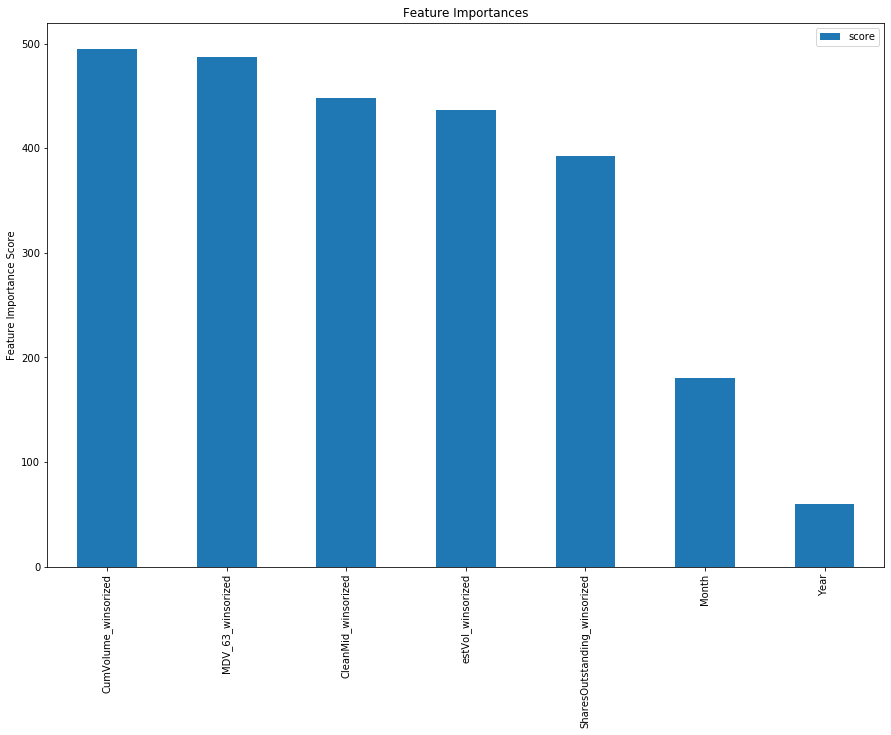

In [16]:
keys = my_model.feature_name_
values = my_model.feature_importances_

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='bar', title='Feature Importances', figsize = (15,10)) ## plot top 40 features
plt.ylabel('Feature Importance Score')